<a href="https://colab.research.google.com/github/SriSathwik1905/Diabetic-Retinopathy-VIT/blob/main/Vit_alone(base_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow_hub opendatasets scikit-learn matplotlib seaborn


# 📦 1. Install and Import Required Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import opendatasets as od


# 📁 2. Load Dataset using opendatasets (or manually if downloaded)

In [ ]:
import opendatasets as od
# Example: Replace with your actual Kaggle dataset URL
od.download('https://www.kaggle.com/datasets/kssanjaynithish03/retinal-fundus-images')

Skipping, found downloaded files in "./retinal-fundus-images" (use force=True to force download)


# 🧼 3. Preprocessing + Data Augmentation

In [ ]:
train_dir = "/content/retinal-fundus-images/Retinal Fundus Images/train"
val_dir = "/content/retinal-fundus-images/Retinal Fundus Images/val"
test_dir = "/content/retinal-fundus-images/Retinal Fundus Images/test"

dr_stage_mapping = {'3.Mild DR': 0, '4.Moderate DR': 1, '5.Severe DR': 2, '6.Proliferate DR': 3}
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', classes=list(dr_stage_mapping.keys()))
val_data = datagen.flow_from_directory(val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', classes=list(dr_stage_mapping.keys()))
test_data = datagen.flow_from_directory(test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', shuffle=False, classes=list(dr_stage_mapping.keys()))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights_dict = dict(enumerate(class_weights))


Found 10206 images belonging to 4 classes.
Found 211 images belonging to 4 classes.
Found 516 images belonging to 4 classes.


# 🔧 4. Define Plain Vit Model

In [ ]:
def build_plain_vit():
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    vit = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False)

    # Wrap the vit layer call within a Lambda layer to ensure eager execution.
    # This forces the input to be converted to a concrete tensor before being passed to vit.
    x = tf.keras.layers.Lambda(lambda inputs: vit(inputs))(inputs)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model_plain_vit = build_plain_vit()
model_plain_vit.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_plain_vit.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,948 (386.52 KB)

 Trainable params: 98,948 (386.52 KB)

 Non-trainable params: 0 (0.00 B)

# 5. 🚀 Train the **Model**

In [ ]:
history = model_plain_vit.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 153s 449ms/step - accuracy: 0.5101 - loss: 1.0717 - val_accuracy: 0.5829 - val_loss: 0.7934
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 116s 364ms/step - accuracy: 0.6258 - loss: 0.6708 - val_accuracy: 0.6019 - val_loss: 0.7564
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 117s 368ms/step - accuracy: 0.6602 - loss: 0.6041 - val_accuracy: 0.7062 - val_loss: 0.6114
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 121s 378ms/step - accuracy: 0.6846 - loss: 0.5703 - val_accuracy: 0.6066 - val_loss: 0.7405
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 118s 370ms/step - accuracy: 0.6883 - loss: 0.5494 - val_accuracy: 0.6919 - val_loss: 0.5956
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 119s 371ms/step - accuracy: 0.7108 - loss: 0.5336 - val_accuracy: 0.6682 - val_loss: 0.6130
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 119s 371ms/step - accuracy: 0.7081 - loss: 0.5035 - val_accuracy: 0.6493 - val_loss: 0.6632
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 118s 371ms/step - accuracy: 0.7136 -

# 6. 📊 Evaluate the Model

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 567ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.58      0.57       102
           1       0.77      0.78      0.77       216
           2       0.68      0.78      0.72       107
           3       0.74      0.56      0.64        91

    accuracy                           0.70       516
   macro avg       0.69      0.67      0.68       516
weighted avg       0.70      0.70      0.70       516



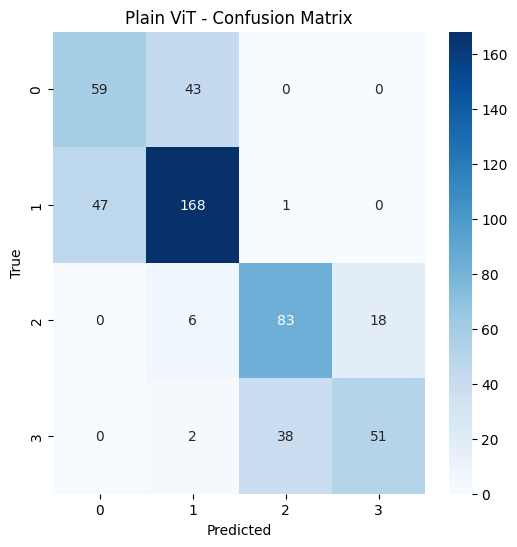

In [ ]:
preds = model_plain_vit.predict(test_data)
y_true = test_data.classes
y_pred = np.argmax(preds, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Plain ViT - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


# 📊 7. Plot Training and Validation Curves

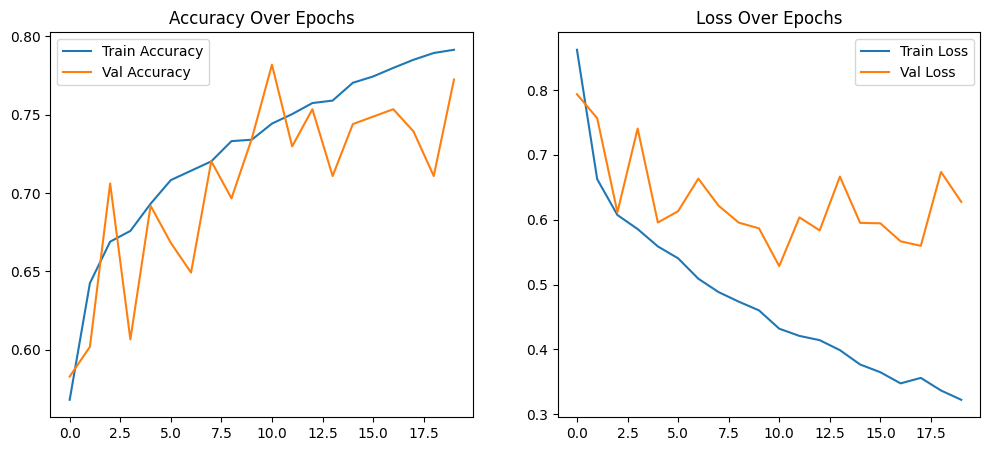

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Over Epochs')
plt.show()


# 📈 8. Evaluate Model (Confusion Matrix, Classification Report, ROC)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step


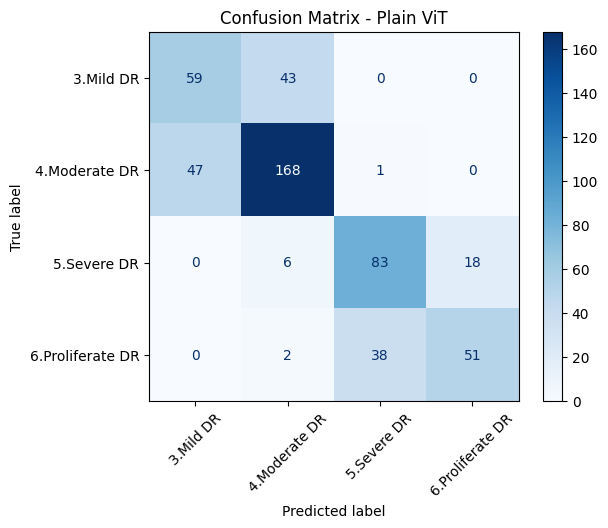

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get ground truth and predictions
y_true = test_data.classes
y_pred_probs = model_plain_vit.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(dr_stage_mapping.keys()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Plain ViT")
plt.show()


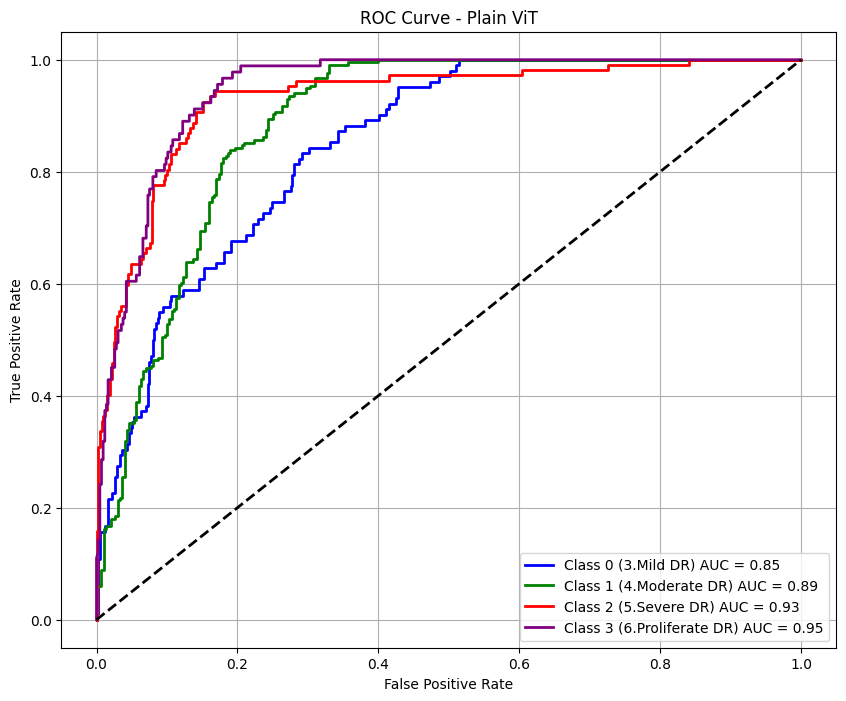

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize true labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'green', 'red', 'purple'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} ({list(dr_stage_mapping.keys())[i]}) AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Plain ViT")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
